# Bolivian Musicians - Artist Segmentation

### Overview
Bolivian musicians are very talented but unfortunately they're not given the attention they deserve. This data-based project aims to promote bolivian artists and make them more visible for locals and the world.

The project consists in:
- The construction of a dataset of bolivian artists by fetching public Spotify data.

- The application of data clustering techniques to segment the collected data and gain
  artists description.
- The implementation of a web app for data visualization and knowledge-based artist recommendations.


### Problem Statement
Since I could not find any dataset of bolivian artists, I had to build one from scratch. As far as I know this is the first dataset of Bolivian artists. The details of the data collection are [here](https://github.com/leanguardia/bolivian-music#dataset-construction).

By nature, music is very varied and therefore artists are even more. Artists can play different genres of music in different languages, with collaborations and sound influences. There are old, traditional and trending artists with different listener targets. For this matter, unsupervised learning is applied to perform automatic artists segmentation or clustering. The expected outcome is to gain deeper understanding of the data and use it the organize the recommendation system.

This notebook contains:
- Data Analysis
- Artist Clustering
- Results and Discussion
- Conclusions and Recommendations

### Metrics
- **Number of Partitions:** Different number of groups is tested with different subsets of the dataset and with extended features as well. Different interpretations of this values are discussed in the context of the business problem.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
%matplotlib inline

In [2]:
df = pd.read_csv('data/artists.csv')
df.shape

(218, 6)

In [3]:
df.head()

,artist_id,name,popularity,followers,genres,img_url
0,0tkboyBYNymYytYlb9EXkN,Los Kjarkas,56,97487,"['andean', 'charango', 'folklore boliviano']",https://i.scdn.co/image/79cf21eb7afee7040e0bc3...
1,30DQw23SjsbMLFlhia84jN,Elias Ayaviri,48,47475,['hip hop boliviano'],https://i.scdn.co/image/d031b0c224b238177d54b1...
2,2oM7LqPaoCUcHHHnsTtgn1,Bonny Lovy,47,35377,"['cumbia boliviana', 'pop reggaeton']",https://i.scdn.co/image/782b72dd80898104191c44...
3,0hkFv9719WLJ2uupZTn0ru,Savia Andina,44,27858,"['andean', 'folklore boliviano']",https://i.scdn.co/image/2aa0046a50d2b0a7fb1412...
4,119DPASXtwEkIiAoRSOUR8,Proyección,43,19856,"['andean', 'folklore boliviano']",https://i.scdn.co/image/ab67616d0000b273b9306d...


## Analysis
### Data Exploration

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   artist_id   218 non-null    object
 1   name        218 non-null    object
 2   popularity  218 non-null    int64 
 3   followers   218 non-null    int64 
 4   genres      218 non-null    object
 5   img_url     205 non-null    object
dtypes: int64(2), object(4)
memory usage: 10.3+ KB


In [5]:
quantitative_cols = ['popularity', 'followers']
desc = df[quantitative_cols].describe()
desc

,popularity,followers
count,218.000000,218.000000
mean,17.587156,2757.105505
std,12.351765,8346.236998
min,0.000000,0.000000
25%,7.000000,159.000000
50%,16.000000,620.000000
75%,27.000000,1970.000000
max,56.000000,97487.000000


In [6]:
qualitative_cols = [col for col in df.columns if col not in quantitative_cols]
df[qualitative_cols].describe()

,artist_id,name,genres,img_url
count,218,218,218,205
unique,218,218,26,203
top,3U5KZkwiSmACysZTJIvjgU,Mistika,[],https://i.scdn.co/image/ab67616d0000b273d1be9a...
freq,1,1,41,2


#### Missing Values

In [7]:
df.isna().sum()

artist_id      0
name           0
popularity     0
followers      0
genres         0
img_url       13
dtype: int64

**Note:** Despite the first 4 columns not having any missing values. The `genre` column should be treated differently becuase it represents a list. Counting missing values should be treated differently because this series is a string, so `[]` evaluates as _non-null_.

In [8]:
# Genres
no_genres = df[df.genres == '[]']
print(f"There are {no_genres.shape[0]} / {df.shape[0]} artists with no genres associated")
no_genres

There are 41 / 218 artists with no genres associated


,artist_id,name,popularity,followers,genres,img_url
139,32SCJ5f4CGlRH7wTOhzyGn,Yara,21,304,[],https://i.scdn.co/image/ab67616d0000b27360a656...
147,685o6XB8DXyM44ukdU5ebX,Scooby Groovy Doo,1,249,[],https://i.scdn.co/image/ab67616d0000b273ea83cd...
150,7HLwXZlNuVlAIXKhOYCk1E,Doble Via,12,234,[],https://i.scdn.co/image/ab67616d0000b2739cf1e4...
163,6sKxxYIo74SVq0e09pNUCT,Icaro,6,158,[],https://i.scdn.co/image/ab67616d0000b2736b6230...
165,3MCqjNuqAL5Ovan3YZZfL4,Lapsus,1,138,[],https://i.scdn.co/image/ab67616d0000b273574321...
167,1JypRMOBn4rkHvWMOT694Q,Nanda Manachi & Savia Andino,15,129,[],https://i.scdn.co/image/ab67616d0000b2731ced1b...
168,2B2jM15msacseMZ741IMHy,Capital,2,125,[],https://i.scdn.co/image/ab67616d0000b2739c658e...
170,05c0eIYflmDPeu1mC1eDrg,Grupo Karacol & Adanis Delgado,11,103,[],https://i.scdn.co/image/ab67616d0000b2736de993...
172,31XQYjxS44AkYTM3b3tK1O,José Luis Cordova,20,101,[],https://i.scdn.co/image/ab67616d0000b2738b8b0c...
173,1Jvpk8cOcAn8rx1f40hCZt,K'achas,13,94,[],https://i.scdn.co/image/ab67616d0000b273587b72...


In [9]:
# img_url
df[df.img_url.isnull()]

,artist_id,name,popularity,followers,genres,img_url
27,0zeMCZBKizCfliQhG6rwGh,America Pop,0,4963,['cumbia boliviana'],NaN
30,7gs6RrJmRq75GL9PYwCX0L,Grupo Maroyu,1,4349,['cumbia boliviana'],NaN
63,1bCReWtNr9XkS0fQ3XbmpZ,Grupo Iberia de Bolivia,2,1643,['cumbia boliviana'],NaN
80,1giB2N76W0f0pC2Z8igC14,Renovacion Andina,17,1135,['salay'],NaN
86,5ifRgTaaAXxScj0lxS7wHK,Erick Claros,0,1046,['hip hop boliviano'],NaN
131,6B9hIrdZXur6eQKsCDtqM0,Grupo Conexión de Bolivia,0,364,['cumbia boliviana'],NaN
181,0NteB9nhib2gnBQti5C5PN,Runakay Bolivia,0,54,['salay'],NaN
184,22vbrs8DqWQ0wN5zgPV2Uz,Mara Bolivia,9,49,['salay'],NaN
197,6uQ2u5yv5t8Tje140MNP4U,AYNA BOLIVIA,0,19,['salay'],NaN
210,6Jhh309jMxQmDMHco40CcU,Kollasuyo,0,5,['salay'],NaN


It is not necessary to remove this elements because they represent artists existing in real life who might have not created an account in Spotify or simply did not upload any picture.

#### Duplicated values

In [10]:
# Duplicates by id or name.
df[df.duplicated('artist_id') | df.duplicated('name')]

,artist_id,name,popularity,followers,genres,img_url


**Note:** Duplicates were removed right after this dataset was created, the implementation is in the `clean_artists` function found in `artists_collector.py`.

### Data Visualization
#### Popularity

In [11]:
df.sort_values('popularity', ascending=False).head(10)

,artist_id,name,popularity,followers,genres,img_url
0,0tkboyBYNymYytYlb9EXkN,Los Kjarkas,56,97487,"['andean', 'charango', 'folklore boliviano']",https://i.scdn.co/image/79cf21eb7afee7040e0bc3...
6,0SWtMcmZLgP04Kj5x0eCxa,azul azul,50,16390,['latin pop'],https://i.scdn.co/image/368c867ee65a75b5b5a052...
33,3U5KZkwiSmACysZTJIvjgU,Grupo Veneno,48,3701,['cumbia boliviana'],https://i.scdn.co/image/ab67616d0000b2737c536a...
1,30DQw23SjsbMLFlhia84jN,Elias Ayaviri,48,47475,['hip hop boliviano'],https://i.scdn.co/image/d031b0c224b238177d54b1...
2,2oM7LqPaoCUcHHHnsTtgn1,Bonny Lovy,47,35377,"['cumbia boliviana', 'pop reggaeton']",https://i.scdn.co/image/782b72dd80898104191c44...
3,0hkFv9719WLJ2uupZTn0ru,Savia Andina,44,27858,"['andean', 'folklore boliviano']",https://i.scdn.co/image/2aa0046a50d2b0a7fb1412...
4,119DPASXtwEkIiAoRSOUR8,Proyección,43,19856,"['andean', 'folklore boliviano']",https://i.scdn.co/image/ab67616d0000b273b9306d...
9,1pbcskpK1qePXm3sYvYu4o,Chila Jatun,42,15064,['andean'],https://i.scdn.co/image/dcfe2ab49d0de0c8a4cd3f...
12,4EBLOxVwhNdq0BbTy0M6xN,Llajtaymanta,41,9888,"['andean', 'folklore boliviano', 'huayno']",https://i.scdn.co/image/ef8d4a536e92f191ffdfe8...
8,1IYPsxunWpJvDYA1Por8dI,Diego Ríos,41,15360,['cumbia boliviana'],https://i.scdn.co/image/2136977d295eebc7f071fa...


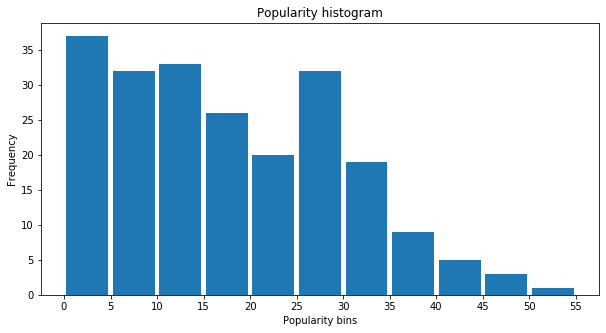

In [12]:
bins = np.arange(0, 60, 5)
ax = df.popularity.plot.hist(bins=bins, rwidth=0.9, figsize=(10,5));
ax.set_xlabel('Popularity bins'); ax.set_title('Popularity histogram')
plt.xticks(bins, bins);

Bimodal distribution skewed to the right. Half of the data has 16 popularity points or less.

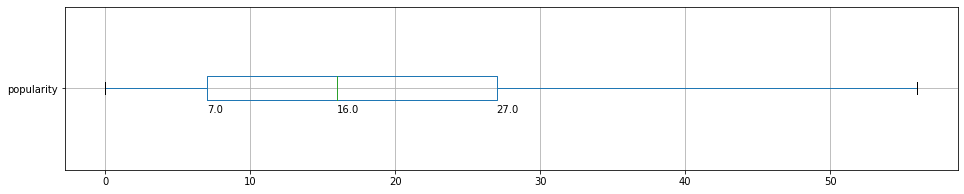

In [13]:
ax = df.boxplot(column='popularity', vert=False, figsize=(16,3));
ax.annotate(df.popularity.median(), (df.popularity.median(), 0.85))
ax.annotate(desc.popularity['25%'], (desc.popularity['25%'], 0.85))
ax.annotate(desc.popularity['75%'], (desc.popularity['75%'], 0.85));

No outliers found.

#### Followers

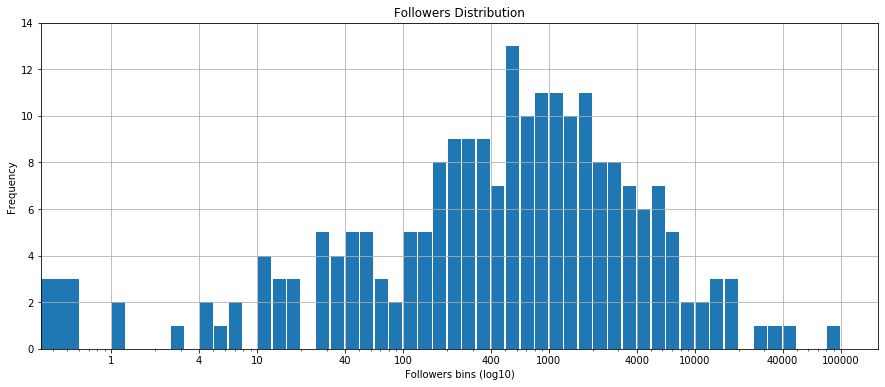

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
plt.xscale('log')

positive_followers = df.followers[df.followers > 0]
no_followers = df[df.followers == 0].shape[0]
positive_followers_log = np.log10(positive_followers)

bin_edges = 10 ** np.arange(0, positive_followers_log.max()+0.1, 0.1)
ax.hist(positive_followers, bins=bin_edges, rwidth=0.90)
plt.bar(0.1, no_followers, width = 1)

xticks = [1,4,10, 40, 100, 400, 1000, 4000, 10000, 40000, 100000]
plt.xticks(xticks, xticks)
yticks = np.arange(0, 16, 2)
plt.yticks(yticks, yticks)
plt.title("Followers Distribution"); plt.grid()
plt.ylabel("Frequency"); plt.xlabel("Followers bins (log10)");

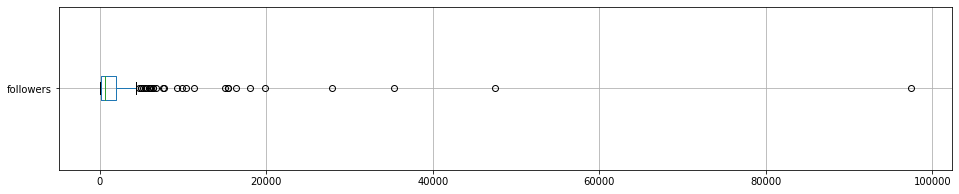

In [15]:
# Outliers
ax = df.boxplot(column='followers', vert=False, figsize=(16,3));

In the case of `followers`, many artists are outliers.

In [16]:
Q1 = desc.followers['25%']
Q3 = desc.followers['75%']
IQR = Q3 - Q1
followers_limit = Q3 + 1.5 * IQR

outliers = df[(df.followers >= followers_limit)].copy()
print("Outliers:", outliers.shape[0], '/', df.shape[0], "elements with more than", followers_limit, 'followers',
      "(", round(outliers.shape[0] / df.shape[0], 2) * 100, "%).")
outliers.head()

Outliers: 29 / 218 elements with more than 4686.5 followers ( 13.0 %).


,artist_id,name,popularity,followers,genres,img_url
0,0tkboyBYNymYytYlb9EXkN,Los Kjarkas,56,97487,"['andean', 'charango', 'folklore boliviano']",https://i.scdn.co/image/79cf21eb7afee7040e0bc3...
1,30DQw23SjsbMLFlhia84jN,Elias Ayaviri,48,47475,['hip hop boliviano'],https://i.scdn.co/image/d031b0c224b238177d54b1...
2,2oM7LqPaoCUcHHHnsTtgn1,Bonny Lovy,47,35377,"['cumbia boliviana', 'pop reggaeton']",https://i.scdn.co/image/782b72dd80898104191c44...
3,0hkFv9719WLJ2uupZTn0ru,Savia Andina,44,27858,"['andean', 'folklore boliviano']",https://i.scdn.co/image/2aa0046a50d2b0a7fb1412...
4,119DPASXtwEkIiAoRSOUR8,Proyección,43,19856,"['andean', 'folklore boliviano']",https://i.scdn.co/image/ab67616d0000b273b9306d...


(189, 6)


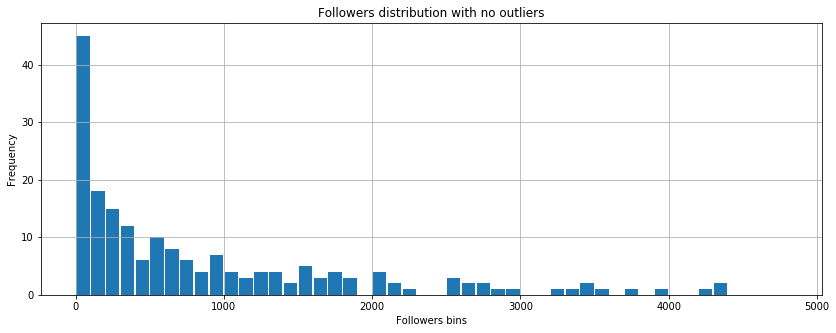

In [17]:
def remove_outliers(df):
    Q1 = df.followers.quantile(.25)
    Q3 = df.followers.quantile(.75)
    IQR = Q3 - Q1
    followers_limit = Q3 + 1.5 * IQR
    return df[df.followers <= followers_limit].copy()
non_outliers = remove_outliers(df)
print(non_outliers.shape)
ax = non_outliers.followers.plot.hist(rwidth=0.9, bins=np.arange(0,4800+100,100), figsize=(14,5))
ax.set_title('Followers distribution with no outliers'); ax.set_xlabel("Followers bins"); plt.grid()

#### Popularity and Followers

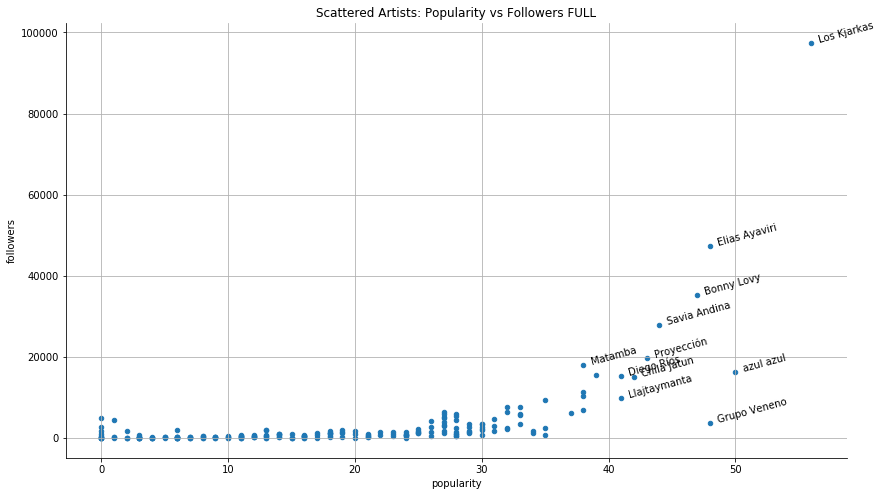

In [18]:
ax = df.plot.scatter(x='popularity', y='followers', figsize=(14,8))
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False); plt.grid()
popularity_thrs = 40
followers_thrs = 18000
top_artists = df[(df.popularity >= popularity_thrs) | (df.followers >= followers_thrs)]

for i, row in top_artists.iterrows():
    ax.annotate(row['name'], (row['popularity']+0.5, row['followers']), rotation=15)
ax.set_title("Scattered Artists: Popularity vs Followers FULL");

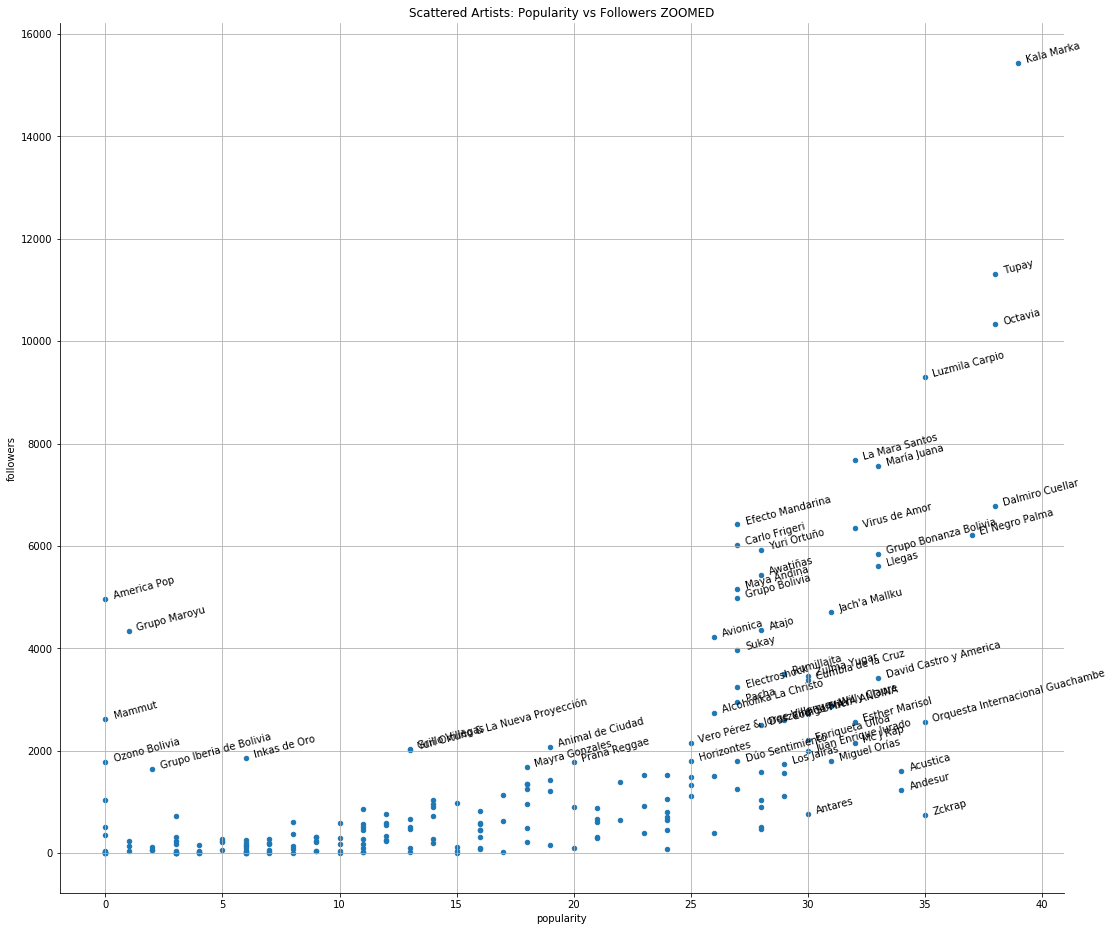

In [19]:
# Zoomed Plot
zoomed_artists = df[(df.popularity < popularity_thrs) & (df.followers < followers_thrs)]
ax = zoomed_artists.plot.scatter(x='popularity', y='followers', figsize=(18,16))
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False); plt.grid()
ax.set_title("Scattered Artists: Popularity vs Followers ZOOMED");

mid_artists = zoomed_artists[(zoomed_artists.popularity >= 30) | (zoomed_artists.followers >= 1600)]
for i, row in mid_artists.iterrows():
    ax.annotate(row['name'], (row['popularity']+0.3, row['followers']), rotation=15)

#### Genres

Number of genres: 19


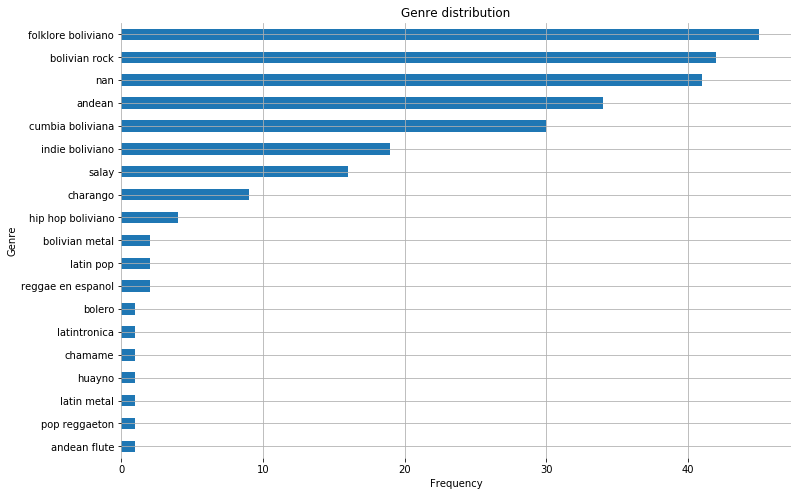

In [20]:
df.genres = df.genres.apply(literal_eval)
def plot_genre_dist(df):
    exploded = df.genres.explode()
    print("Number of genres:", len(exploded.unique()))
    ax = exploded.value_counts(dropna=False).sort_values(ascending=True).plot.barh(figsize=(12,8))
    ax.set_xlabel('Frequency'); ax.set_ylabel('Genre'); ax.set_title('Genre distribution');
    ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False); plt.grid();
    ax.spines['left'].set_visible(False); ax.spines['bottom'].set_visible(False);
plot_genre_dist(df)

Number of genres: 16


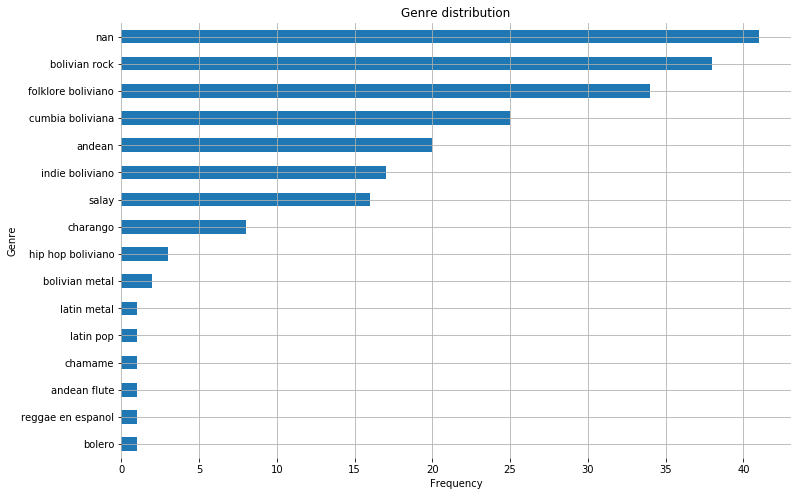

In [21]:
non_outliers.genres = non_outliers.genres.apply(literal_eval)
plot_genre_dist(non_outliers)

Removing outliers results in loosing 29 artists and 3 genres.

## Methodology

Kmeans is the unsupervised learning technique used for data clustering. It is a general purpose algorithm that assigns data points to a given number of clusters by calculating the similarity of each one of them with the closets center. The centers are reallocated in each iteration and the algorithm converges when the total sum-of-squares within cluster is minimized. https://scikit-learn.org/stable/modules/clustering.html#k-means.

Data will be prepared, and then KMeans analysis will be implemented for the following subsets of data:
1. Followers and Popularity
1. Followers and Popularity without outliers
2. Followers, Popularity and genres
3. Followers, Popularity and genres without outliers

### Data Preprocessing

The `genres` column contains a list of genres. These will be split in dummy columns to represent wheter an artist is labeled with a genre `1` or not `0`.

In [22]:
genres = pd.Series(df.genres.explode().unique())
genres = genres.replace(np.nan, 'NaN').tolist()
genres

['andean',
 'charango',
 'folklore boliviano',
 'hip hop boliviano',
 'cumbia boliviana',
 'pop reggaeton',
 'bolivian rock',
 'reggae en espanol',
 'latin pop',
 'huayno',
 'latintronica',
 'indie boliviano',
 'bolivian metal',
 'salay',
 'bolero',
 'andean flute',
 'chamame',
 'NaN',
 'latin metal']

**Note:** In this case it makes sense to include `NaN` values to the model. There might be artists which genre was not assigned by  Spotify for a specific reason. E.g. low popularity.

In [23]:
# Create a container to fill dummy variables
zeroes = np.zeros((df.shape[0], len(genres)))
dummies = pd.DataFrame(zeroes, columns=genres, index=df.index, dtype=int)

# Fill dummy variables for each genre in the list.
for i, artist_genres in enumerate(df.genres):
        indices = np.unique(dummies.columns.get_indexer(artist_genres))
        dummies.iloc[i, indices] = 1

# Merge dummies to df
df_model = pd.concat([df, dummies], axis=1)
df_model.head()

,artist_id,name,popularity,followers,genres,img_url,andean,charango,folklore boliviano,hip hop boliviano,...,huayno,latintronica,indie boliviano,bolivian metal,salay,bolero,andean flute,chamame,NaN,latin metal
0,0tkboyBYNymYytYlb9EXkN,Los Kjarkas,56,97487,"[andean, charango, folklore boliviano]",https://i.scdn.co/image/79cf21eb7afee7040e0bc3...,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,30DQw23SjsbMLFlhia84jN,Elias Ayaviri,48,47475,[hip hop boliviano],https://i.scdn.co/image/d031b0c224b238177d54b1...,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2oM7LqPaoCUcHHHnsTtgn1,Bonny Lovy,47,35377,"[cumbia boliviana, pop reggaeton]",https://i.scdn.co/image/782b72dd80898104191c44...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0hkFv9719WLJ2uupZTn0ru,Savia Andina,44,27858,"[andean, folklore boliviano]",https://i.scdn.co/image/2aa0046a50d2b0a7fb1412...,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,119DPASXtwEkIiAoRSOUR8,Proyección,43,19856,"[andean, folklore boliviano]",https://i.scdn.co/image/ab67616d0000b273b9306d...,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Implementation

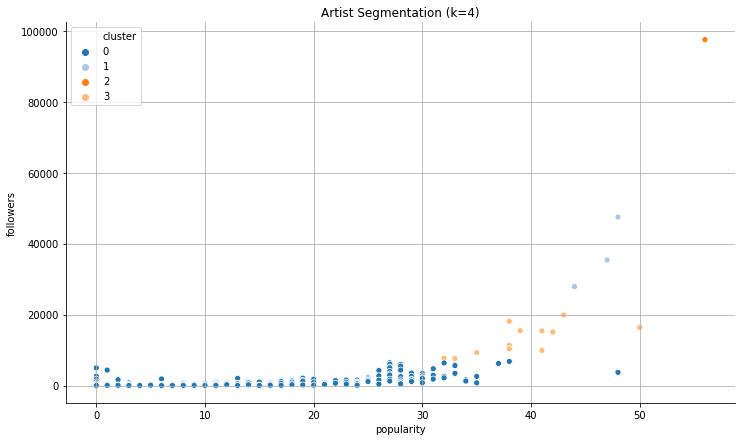

In [24]:
from sklearn.cluster import KMeans
import numpy as np

def plot_clusters(dataframe, clusters):
    cluster_series = pd.Series(clusters, name="cluster", dtype=int, index=dataframe.index)
    df_clusters = pd.concat([dataframe, cluster_series], axis=1)
    k = len(pd.unique(clusters))
    fig, ax = plt.subplots(figsize=(12,7))
    sns.scatterplot(data=df_clusters, x='popularity', y='followers', hue='cluster', ax=ax, palette="tab20")

    ax.set_title("Artist Segmentation (k={})".format(k)); ax.set_xlabel('popularity')
    ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False); plt.grid();
    return df_clusters
    
def segment_data(X, k):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    clusters = kmeans.labels_
    return kmeans, clusters

features = ['popularity', 'followers'] + genres
kmeans, clusters = segment_data(df_model[features], k=4)
_ = plot_clusters(df_model, clusters)

In [25]:
kmeans.cluster_centers_[:, :2]

array([[1.56881188e+01, 1.17115842e+03],
       [4.63333333e+01, 3.69033333e+04],
       [5.60000000e+01, 9.74870000e+04],
       [3.91666667e+01, 1.30231667e+04]])

**Note:** The Previous segmentation is manly using followers data since the features have not been scaled. `KMeans` uses Euclidean Distance to measure similarity between data points, therefore, data needs to be scaled before fitting the data. (Data Engineering Lesson in course content).

### Refinement
#### Scaling Features

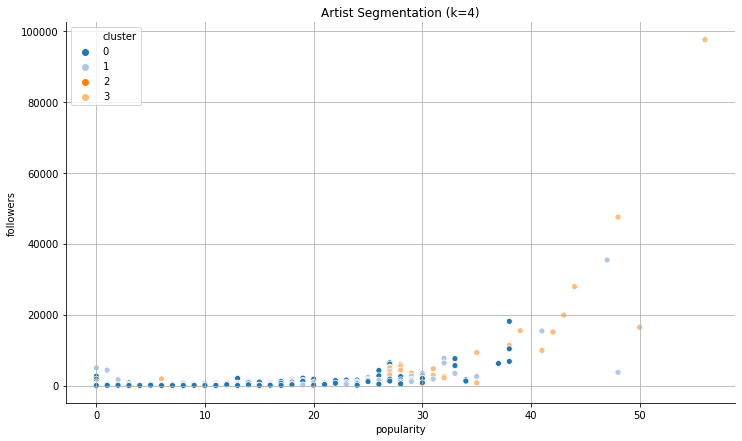

In [26]:
from sklearn.preprocessing import scale

df_model['popularity_std'] = scale(df_model['popularity'])
df_model['followers_std'] = scale(df_model['followers'])

# scaling dummy genres
genres_std = [genre + ' std' for genre in genres]
dummies_std = pd.DataFrame(scale(dummies), columns=genres_std)

# merge scaled data to main df
df_model = pd.concat([df_model, dummies_std], axis=1)

# Segment artists
features = ['popularity_std', 'followers_std'] + genres_std
kmeans, clusters = segment_data(df_model[features], k=4)
_ = plot_clusters(df_model, clusters)

In the previous analysis, popularity, followers, and 19 genres were included. It is clear to see that the algorithm grouped data in more diverse ways. However, the number of clusters was taken arbitrarily.


### Define the number of Clusters
It is necessary to define the most appripriate number of clusters (`k`) for the available data. In some cases [domain knowledge](https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a) is enough. However, in this work the [elbow method](https://towardsdatascience.com/clustering-metrics-better-than-the-elbow-method-6926e1f723a6) is applied.

#### Elbow Method

Consists in running the clustering algorithm for a list of numbers of clusters, find the smallest `k` with less decrease of `wcss` (within cluster squared sums) in the skree plot (the elbow), that is a potential good `k`.

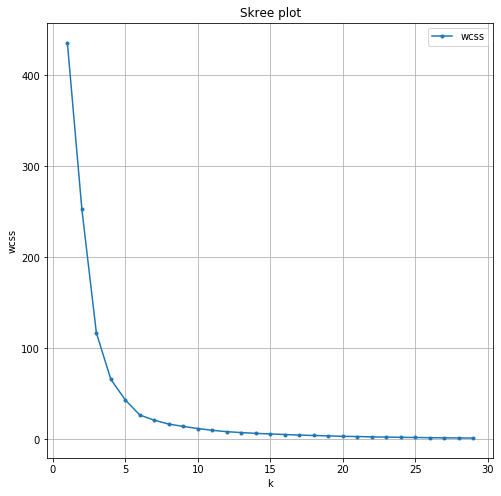

In [27]:
# Analysis 1: popularity and followers
features = ['popularity_std', 'followers_std']
clusters_list = np.arange(1,30)
wcss = []; labels = []
X = df_model[features]

for k in clusters_list:
    kmeans, clusters = segment_data(X, k)
    wcss.append(kmeans.inertia_)
    labels.append(clusters)

def plot_skree(clusters_list, wcss):
    clusters_res = pd.DataFrame({'k': clusters_list, 'wcss': wcss})
    ax = clusters_res.plot(x='k', y='wcss', marker='.', figsize=(8,8))
    ax.set_title('Skree plot'); ax.set_ylabel('wcss'); plt.grid()
plot_skree(clusters_list, wcss)

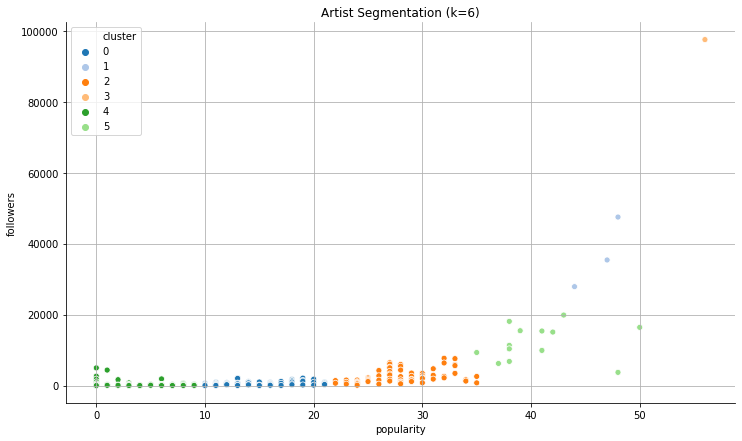

In [28]:
num_of_clusters = 6
clusters_1 = labels[num_of_clusters-1]
df_clusters = plot_clusters(df_model, clusters_1)

From left to right: the first three groups could be labeled as emergent artists with increasing popularity. The folowing groups could be labeled as popular artists because of both, their popularity and number of followers, seem to have a linear correlation. The final two groups could be merged into and named the top artists.

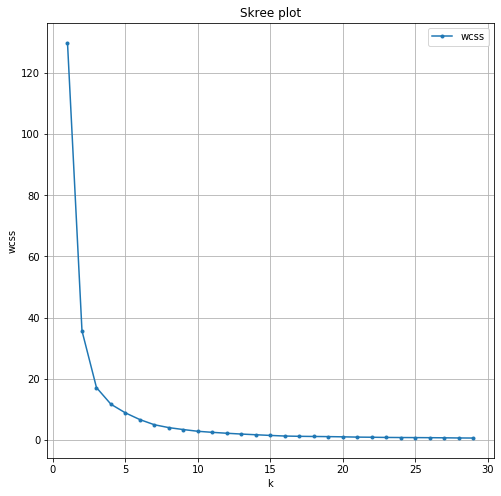

In [29]:
# Analysis 2: Popularity and Followers, no outliers

features = ['popularity_std', 'followers_std']
clusters_list = np.arange(1,30)
wcss = []; labels = []

non_outliers = remove_outliers(df_model) # Remove outliers from prepared data
X = non_outliers[features]

for k in clusters_list:
    kmeans, clusters = segment_data(X, k)
    wcss.append(kmeans.inertia_)
    labels.append(clusters)

plot_skree(clusters_list, wcss)

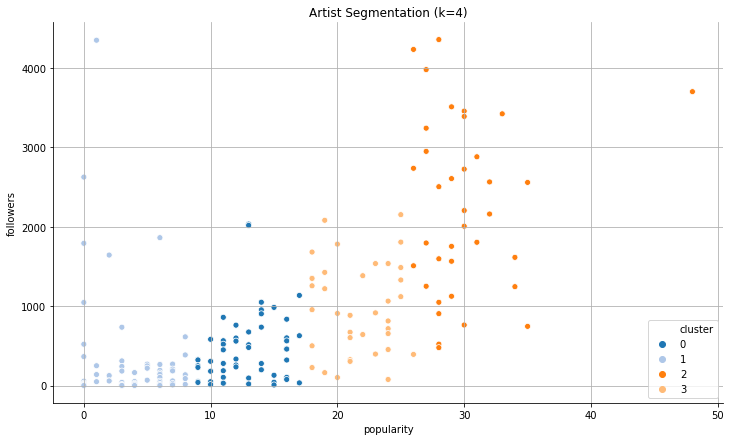

In [30]:
num_of_clusters = 4
clusters_2 = labels[num_of_clusters-1]
df_clusters_2 = plot_clusters(non_outliers, clusters_2)

Similar to the previous analysis, data is stratified by ranges of popularity. Grouping the followers dimension is not that robust since there is high variance. If the 29 outliers are taken as the top artists, the data could be grouped into 5 ranks (of popularity and number of followers).

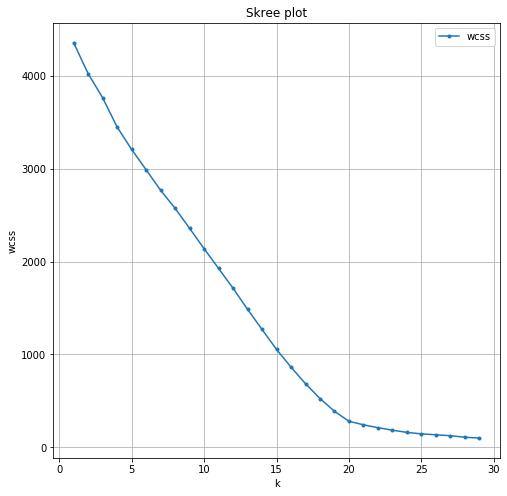

In [31]:
# Analysis 3: popularity, followers and genres
features = ['popularity_std', 'followers_std'] + genres_std
clusters_list = np.arange(1,30)
wcss = []
labels = []
X = df_model[features]

for k in clusters_list:
    kmeans, clusters = segment_data(X, k)
    wcss.append(kmeans.inertia_)
    labels.append(clusters)

plot_skree(clusters_list, wcss)

Interestingly enough the appropriate number of clusters increases to 20 when genres are included in the analysis.

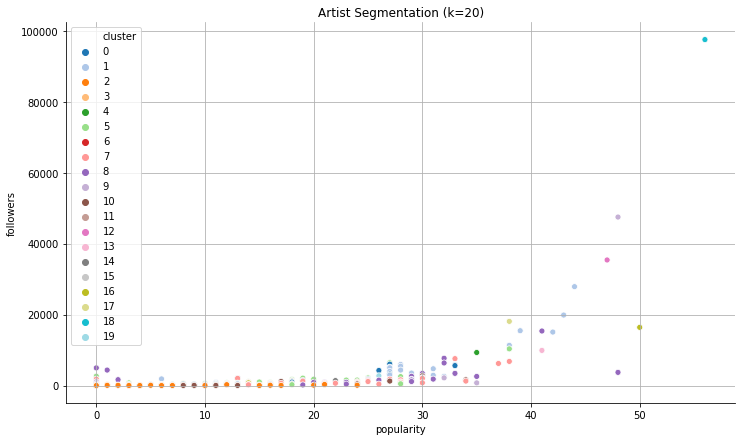

In [32]:
num_of_clusters = 20
clusters_3 = labels[num_of_clusters-1]
df_clusters = plot_clusters(df_model, clusters_3)

Since the outliers make this graphic too difficul to interpret, the same analysis will be made below with the subset with no outliers. However, a heatmap is plotted below to visualize the genres-clusters relation.

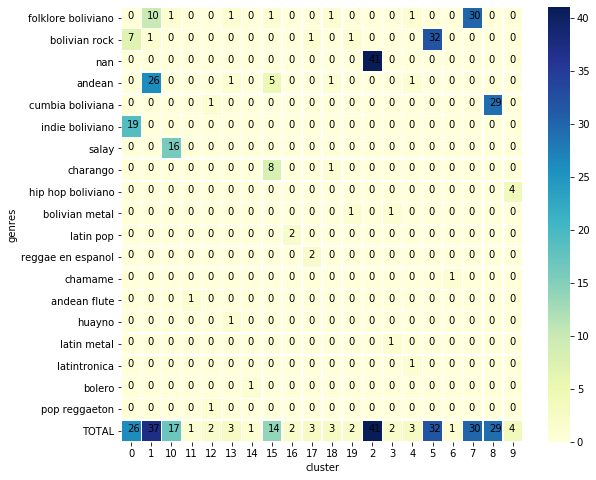

In [33]:
def plot_genre_cluster_map(df):
    genres_cluster = df.explode('genres').astype(str).groupby(['genres', 'cluster']) \
                        .count()['name'].astype(int).unstack(fill_value=0)
    genres_cluster['sum'] = genres_cluster.apply(sum, axis=1)
    genres_cluster = genres_cluster.sort_values(by='sum', ascending=False)
    genres_cluster = genres_cluster.drop(columns='sum')
    
    total_by_cluster = genres_cluster.apply(sum, axis=0)
    genres_cluster.loc['TOTAL'] = total_by_cluster

    fig, ax = plt.subplots(figsize=(9,8))
    sns.heatmap(genres_cluster, linewidth=0.5, cmap="YlGnBu", ax=ax);
    genres_cluster_vals = genres_cluster.values

    for row in range(genres_cluster_vals.shape[0]):
        for col in range(genres_cluster_vals.shape[1]):
            ax.annotate(genres_cluster_vals[row][col], (col+0.3, row+0.55))
plot_genre_cluster_map(df_clusters)

In the previous analysis KMeans grouped artists by their music genders. Most of the clusters collected artists from specific genres exclusively, i.e. _chamame, andean flute, bolero, latin pop_ and _No Genre (nan)_. On the other side, some clusters contain pairs of genres such as cluster 16 with _folklore_ and _andean_ which is related with cluster for _charango_ music.

Similarly, some instances of _rock_ and _indie_ have been grouped in cluster 0. The rest of the clusters group few artists belonging to the rest of unfrequent genres. Some of them are subgenres of the mos populated ones. For example _hayno_ and _chamame_ are two subtypes of _folklore_. 

Below the distribution between clusters and popularity and followers is shown.

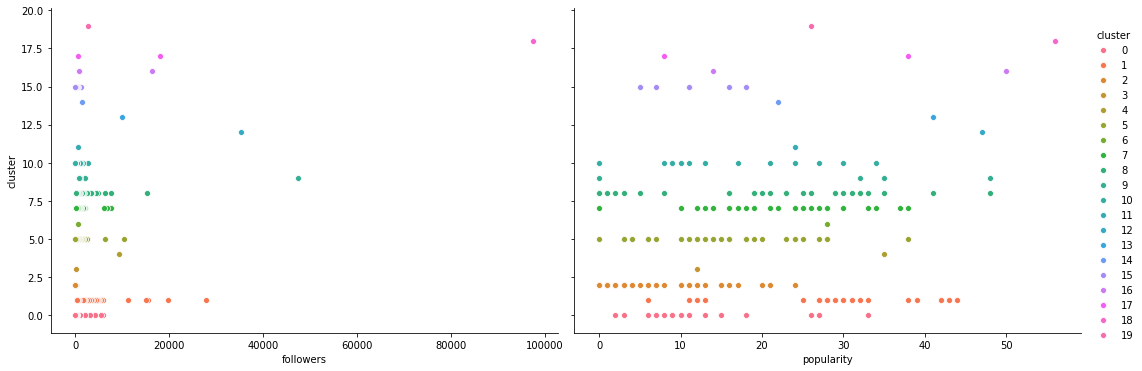

In [34]:
sns.pairplot(df_clusters, x_vars=["followers", "popularity"], y_vars=['cluster'], height=5, aspect=1.5, hue='cluster');

Again, it is difficult to find correlations for the followers distributions because of the outliers present. On the other side, the distribution between cluster and probability does not show an obvious relation. 

Since 20 clusters are too many groups. The elbow method is re-aplied after removing the outliers from the dataset.

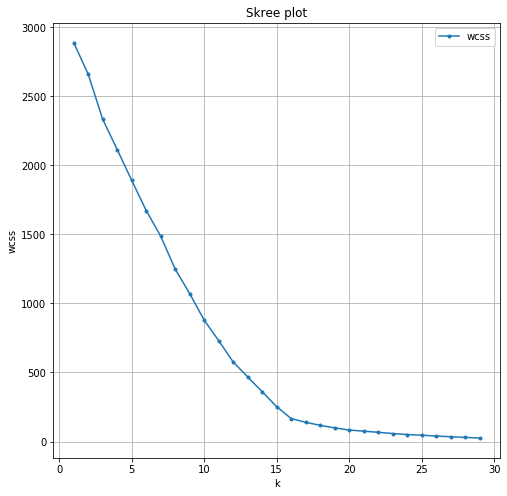

In [35]:
# Analysis 4: Popularity, Followers, genres, no outliers.
features = ['popularity_std', 'followers_std'] + genres_std
clusters_list = np.arange(1,30)
wcss = []
labels = []
X = non_outliers[features]

for k in clusters_list:
    kmeans, clusters = segment_data(X, k)
    wcss.append(kmeans.inertia_)
    labels.append(clusters)

plot_skree(clusters_list, wcss)

After removing the 29 outliers identified above, the data subset has now 16 genres, exactly the same number of apparent best number of clusters.

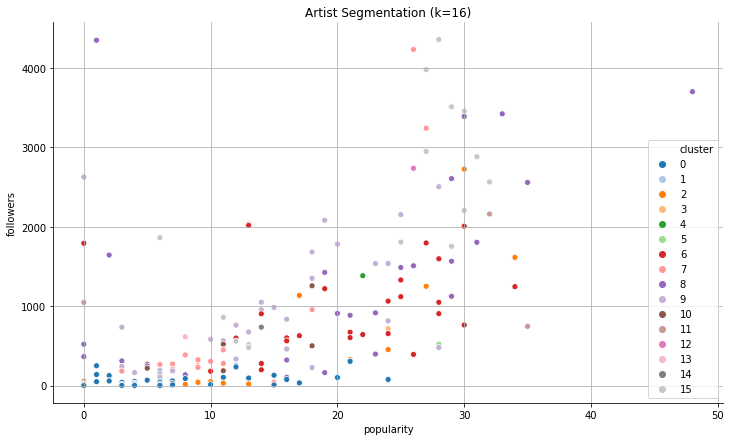

In [36]:
num_of_clusters = 16
clusters_4 = labels[num_of_clusters-1]
df_clusters_reduced = plot_clusters(non_outliers, clusters_4)

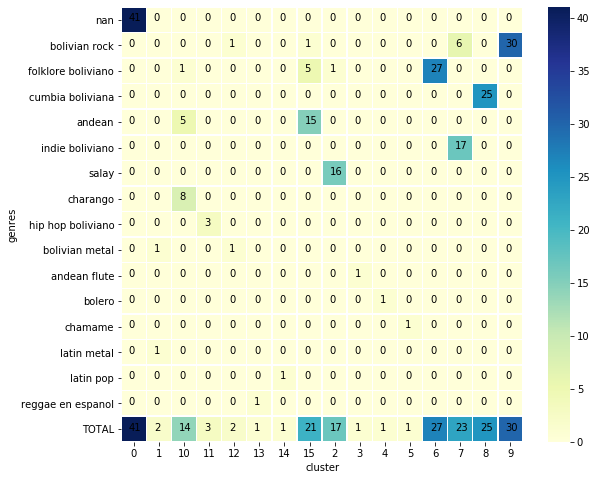

In [37]:
plot_genre_cluster_map(df_clusters_reduced)

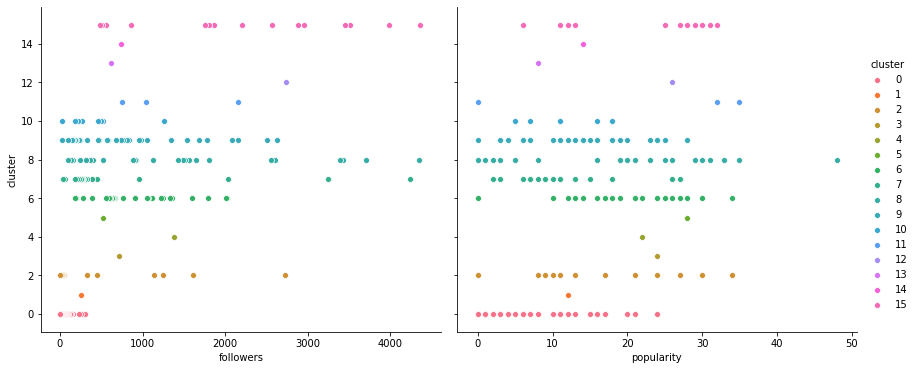

In [38]:
sns.pairplot(df_clusters_reduced, x_vars=["followers", "popularity"], y_vars=['cluster'], height=5, aspect=1.2, hue='cluster');

The segmentation of the subset of data looks similar regardless of the absence of outliers. No new information could be found in comparison with the segmentation of the full dataset. The final analysis is discussed in the following section.

## Results

### Model Evaluation

KMeans is an unsupervised learning algorithm, this implies that data is not labeled and no optimization or objective evaluation can be applied. However, after preparing the data and analysing convenient number of clusters with the elbow method in 4 different subsets of the data, the following results have been met:
- The segmentation of the data including followers and popularity only results in segments of artists which are strongly grouped by popularity ranges of length 10 to 12. (e.g. poularity between 0 to 10, 11 to 23 and so on). This segmentation could be usefil to rank artists and label them with the following example: `top`, `popular`, `thriving`, `emerging`, etc.
- When genres data is included, Kmeans groups artists by that feature and the importance of followers and popularity decreses notably. Some clusters include different genres but these are only models of overlapping genres found in the data, i.e. `Kjarkas` with genres _folklore, andean_ and _charango_. No other valuable insight was found in that analysis for both with and without outliers.


### Justification

- KMeans worked well for the anlaysis of popularity and follwers, the resulting clustering will be used to group artists into ranks in the end of this notebook.
- The segmentation of the data when including genre might have failed because of the following reasons:
  1. The genres data became more important since popularity and followers are poor features. Popularity is highly concentrated in low values. And followers has a large variance and many outliers. Forcing Kmeans to group dataponts by popularity. However, the scaled 20 genres were still more important.
  2. The fundamental problem of this dataset is that it is small, only 200+ datapoints.
  3. The quality of the genres associated to artists is low and misses information in many cases. It would be ideal to improve that information. Some of them were manually added but that work requires more effort. It is highly likely that Spotify labels artsts automatically or perhaps manually, however, it is not representative enough of the reality.

## Conclusion
### Reflection
By the motivation of performing a data science project of my interest I realise that many projects can be done. Opportunities are infinite. I decided to analyse on Music because it is something I am passionate about and I have learned very much the music my home country produces. The main outcome for me is to see in practice how much time and effort it requries to (1) collect data, (2) explore it (3) prepare it and feed it to ML and (3) reflect on the results. All of the stages had their specific challanges and I have ideas on how to improve all of them. Next, I will mention a couple of interesting learnin outcomes I gained throughout this work and then list improvement points for future work.

Learning outcomes:
- I fully agree with the [pyramid of needs of DS](https://hackernoon.com/the-ai-hierarchy-of-needs-18f111fcc007). In this case, I decided to build my own dataset from scratch, and the outcome of the top level ML analysis (tip) strongly depends and is completely founded in the collection of the data. I spent lot of time refining the data, filtering it, trying to include more variety and richness. However, it is still not enough and it can be improved in many ways to make it richer and extend features. I plan to upload it to Kaggle and motivate colleages to work on it when they have time.
- Working in a business problem I decided myself was different from the projects of the Nanodegree in the sense that I really wanted to generate quality outcome. That made me learn more deeply in many fields, specially in statistics, visualization and data clustering. There is much more to learn but now I am much more prepared.

### Improvements
- Unfortunately the API does not offer popularity or followers. However, `tracks_collector.py` can be implemented in order to pull the following information:
   - Number of tracks released
   - First release date
   - Last release date
   - Number of albums
The previous data might help finding non-obvious groups such as new, traditional artists within and across music genres.
- The web version of Spotify shows `Monthly listeners`, data data could be pulled with Web Scrapping techniques.]
- The quality of the genres would need to be improved. For that, more genres should be identified and crowd data-labelling could be implemented in the web app.
- Other scaling methods and segmentation algorithms could be tried.
- Other music streaming services (e.g. Amazon Music, Apply Music, Deezer) might be used to enrich the existing data.
- Advanced: The music spectograms could be encoded and analyzed

### Save Labelled Data
Clusters of Analysis 2 will be taken as incremental ranks and the outliers will be the `top` artist.

In [39]:
labelled = df_clusters_2.copy() # Analysis 2
labelled = labelled[['artist_id', 'name', 'popularity', 'genres', 'img_url', 'cluster']]
labelled

,artist_id,name,popularity,genres,img_url,cluster
29,1CIQKMq8233RjSs4VMk0a9,Atajo,28,"[andean, bolivian rock]",https://i.scdn.co/image/f9a1ab380e03ac9042821a...,2
30,7gs6RrJmRq75GL9PYwCX0L,Grupo Maroyu,1,[cumbia boliviana],NaN,1
31,1kqcnt8DXUkuuRnawXGS38,Avionica,26,"[bolivian rock, indie boliviano]",https://i.scdn.co/image/9eff4eaf9f32624e0ba528...,2
32,45MEz7t5DAOmX0o8fFKA3B,Sukay,27,[andean],https://i.scdn.co/image/ab67616d0000b2731a118d...,2
33,3U5KZkwiSmACysZTJIvjgU,Grupo Veneno,48,[cumbia boliviana],https://i.scdn.co/image/ab67616d0000b2737c536a...,2
...,...,...,...,...,...,...
213,0MfqiQWF3Ia3gMbgxu6gu6,X Siempre Sabaya,3,[],NaN,1
214,7b4FiXD70tUTy79EYPNgwP,Juan Manuel Thorrez,3,[],https://i.scdn.co/image/ab67616d0000b273975ef5...,1
215,1S6elt0a8pmo996HL2y9Gz,Gaston Sosa,0,[],NaN,1
216,0ReBcEK3lxWyrEjmtPcSVA,Grupo Sangre Morena,4,[],https://i.scdn.co/image/ab67616d0000b27330a7c9...,1


In [40]:
outliers.loc[:, 'cluster'] = -1
outliers.head()

,artist_id,name,popularity,followers,genres,img_url,cluster
0,0tkboyBYNymYytYlb9EXkN,Los Kjarkas,56,97487,"['andean', 'charango', 'folklore boliviano']",https://i.scdn.co/image/79cf21eb7afee7040e0bc3...,-1
1,30DQw23SjsbMLFlhia84jN,Elias Ayaviri,48,47475,['hip hop boliviano'],https://i.scdn.co/image/d031b0c224b238177d54b1...,-1
2,2oM7LqPaoCUcHHHnsTtgn1,Bonny Lovy,47,35377,"['cumbia boliviana', 'pop reggaeton']",https://i.scdn.co/image/782b72dd80898104191c44...,-1
3,0hkFv9719WLJ2uupZTn0ru,Savia Andina,44,27858,"['andean', 'folklore boliviano']",https://i.scdn.co/image/2aa0046a50d2b0a7fb1412...,-1
4,119DPASXtwEkIiAoRSOUR8,Proyección,43,19856,"['andean', 'folklore boliviano']",https://i.scdn.co/image/ab67616d0000b273b9306d...,-1


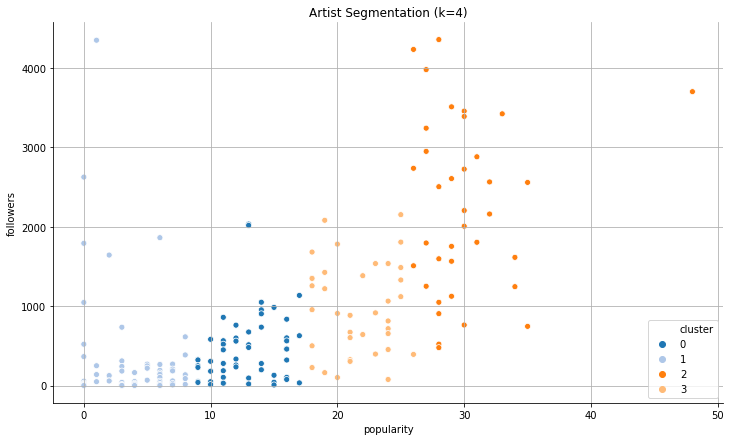

In [41]:
plot_clusters(non_outliers, clusters_2); # Analysis #2

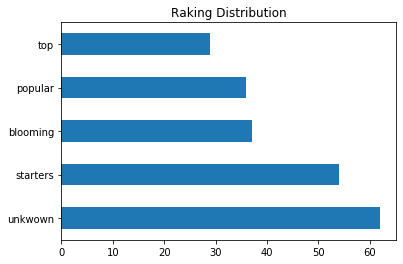

In [42]:
# Re join outliers
labelled = pd.concat([labelled, outliers])

# Map cluster to descriptive rankings.
labelled['ranking'] = labelled.cluster.map({-1: 'top', 2: 'popular', 3: 'blooming', 0: 'starters', 1: 'unkwown'})

labelled.ranking.value_counts().plot.barh(title = 'Raking Distribution');

In [43]:
labelled = labelled.drop(columns='cluster')
labelled.sort_values('followers').to_csv('data/artists_grouped.csv', index=False)